In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 8

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-18-09-18-002956/model-7268352.meta"
# META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-30-lev-30/model.ckpt-3062.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-18-09-18-002956/model-7268352


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 20

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_8_bench", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [15]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e6 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [16]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [17]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    
    compute_and_print_steps(sats, HybridDPLL)
    compute_and_print_steps(sats, ShortCommonDPLL)
    logfile.flush()

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:30<00:00,  1.29it/s]


Within 1e6 steps solved 99 problems out of 100
#Sats: 99; avg step: 85.31; stdev step: 184.84; avg error: 0.47; stdev error: 1.18


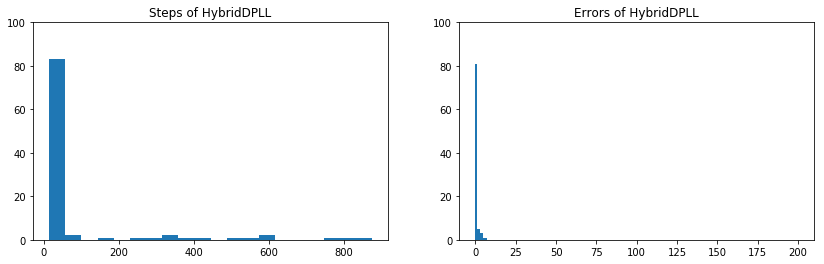

100%|██████████| 100/100 [00:01<00:00, 60.57it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 200.75; stdev step: 193.46; avg error: 2.16; stdev error: 1.16


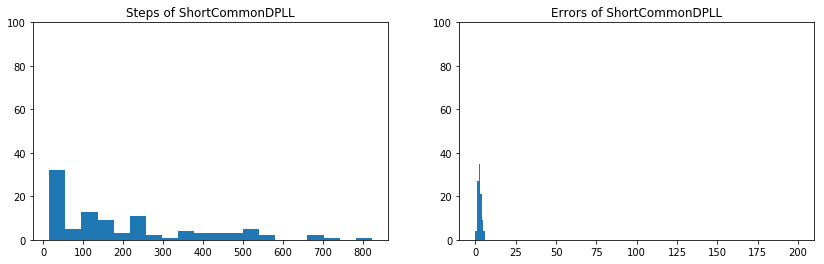

In [18]:
print_all(100, 200, 15)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:22<00:00,  3.99it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.31; stdev step: 12.29; avg error: 0.04; stdev error: 0.20


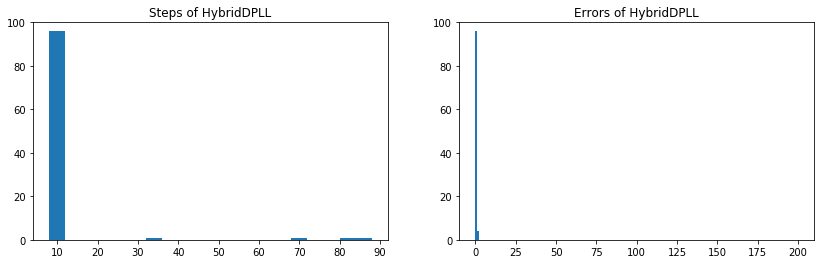

100%|██████████| 100/100 [00:00<00:00, 379.97it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 25.52; stdev step: 21.87; avg error: 1.06; stdev error: 0.83


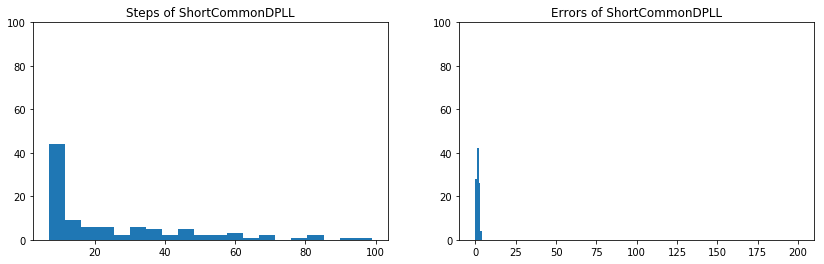

In [19]:
print_all(100, 200, 8)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:38<00:00,  3.54it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 25.13; stdev step: 51.01; avg error: 0.17; stdev error: 0.53


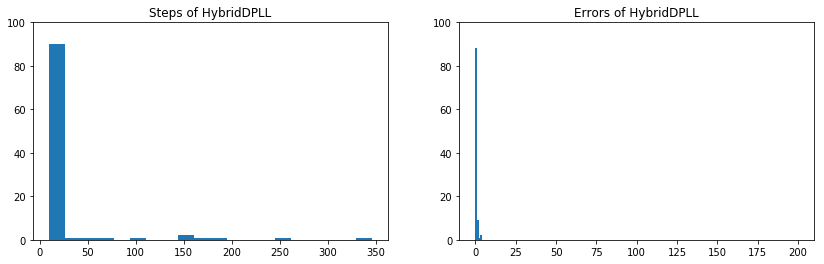

100%|██████████| 100/100 [00:00<00:00, 257.23it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 53.88; stdev step: 45.63; avg error: 1.44; stdev error: 1.00


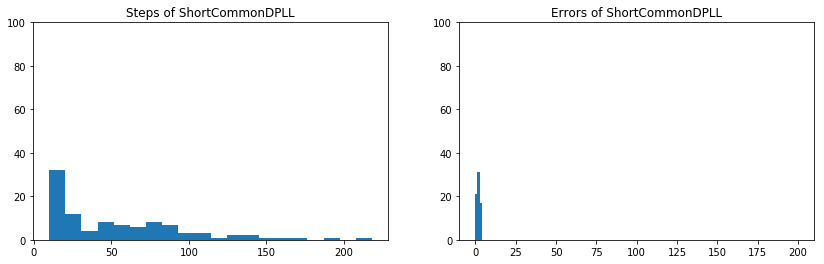

In [20]:
print_all(100, 200, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:47<00:00,  1.95it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 35.19; stdev step: 81.69; avg error: 0.22; stdev error: 0.77


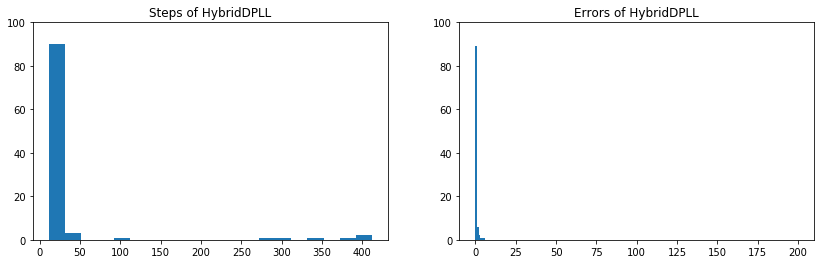

100%|██████████| 100/100 [00:00<00:00, 144.01it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 90.58; stdev step: 83.05; avg error: 1.79; stdev error: 1.10


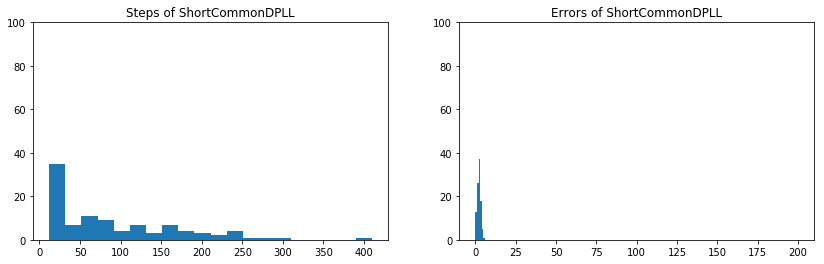

In [21]:
print_all(100, 200, 12)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:29<00:00,  1.57it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 123.53; stdev step: 210.79; avg error: 0.68; stdev error: 1.38


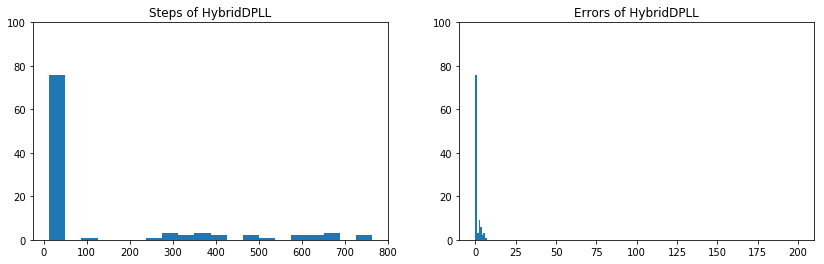

100%|██████████| 100/100 [00:01<00:00, 80.02it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 164.69; stdev step: 161.01; avg error: 2.01; stdev error: 1.20


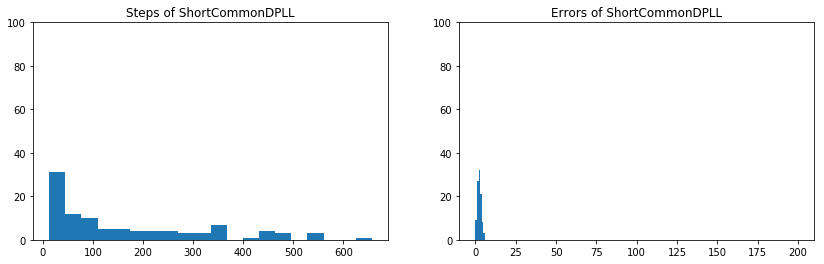

In [22]:
print_all(100, 200, 14)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:24<00:00,  2.21it/s]


Within 1e6 steps solved 99 problems out of 100
#Sats: 99; avg step: 90.45; stdev step: 187.59; avg error: 0.44; stdev error: 1.10


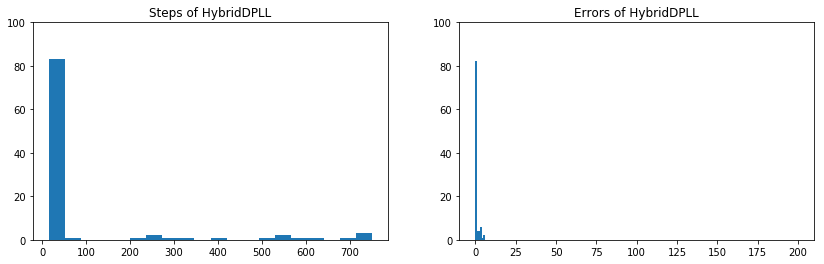

100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


Within 1e6 steps solved 99 problems out of 100
#Sats: 99; avg step: 291.29; stdev step: 255.75; avg error: 2.45; stdev error: 1.22


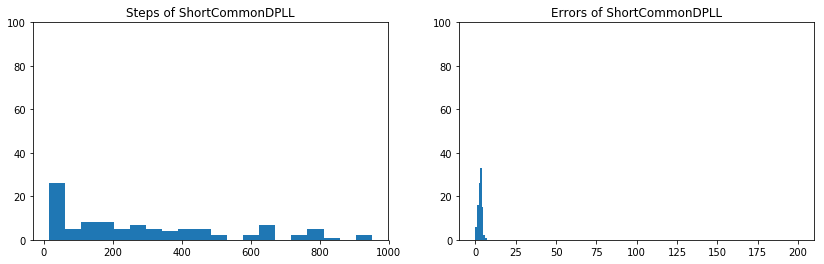

In [23]:
print_all(100, 200, 16)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:06<00:00,  1.12s/it]


Within 1e6 steps solved 83 problems out of 100
#Sats: 83; avg step: 114.70; stdev step: 227.63; avg error: 0.59; stdev error: 1.37


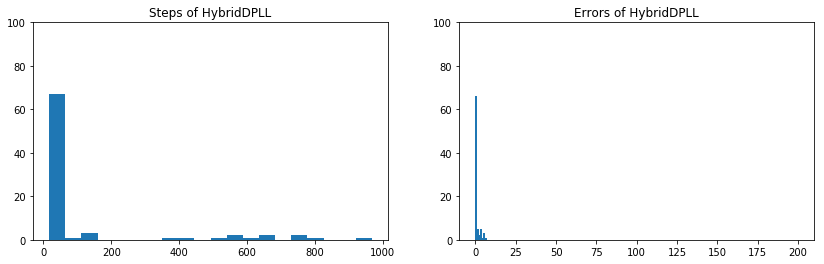

100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


Within 1e6 steps solved 90 problems out of 100
#Sats: 90; avg step: 383.71; stdev step: 301.74; avg error: 2.53; stdev error: 1.35


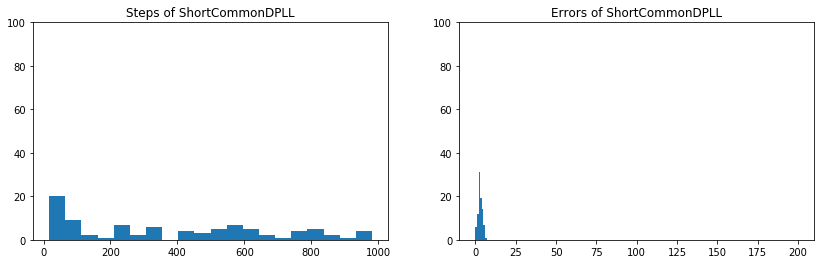

In [24]:
print_all(100, 200, 18)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:30<00:00,  1.04it/s]


Within 1e6 steps solved 76 problems out of 100
#Sats: 76; avg step: 143.78; stdev step: 265.04; avg error: 0.66; stdev error: 1.32


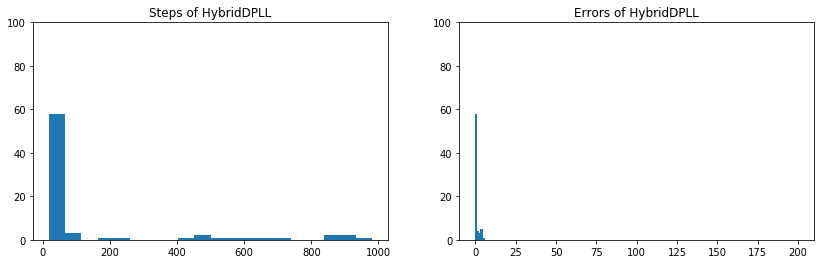

100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


Within 1e6 steps solved 60 problems out of 100
#Sats: 60; avg step: 379.40; stdev step: 282.82; avg error: 3.20; stdev error: 1.39


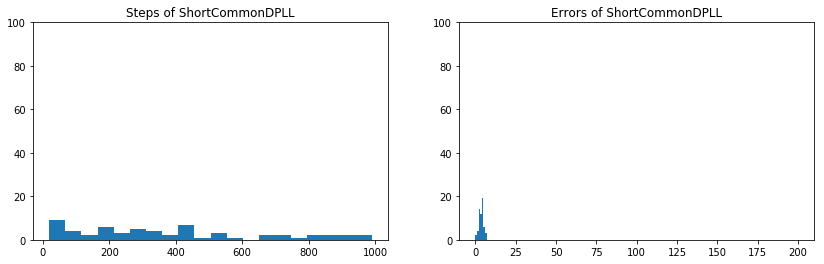

In [25]:
print_all(100, 200, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [03:47<00:00,  1.53s/it]


Within 1e6 steps solved 57 problems out of 100
#Sats: 57; avg step: 98.75; stdev step: 214.49; avg error: 0.33; stdev error: 1.00


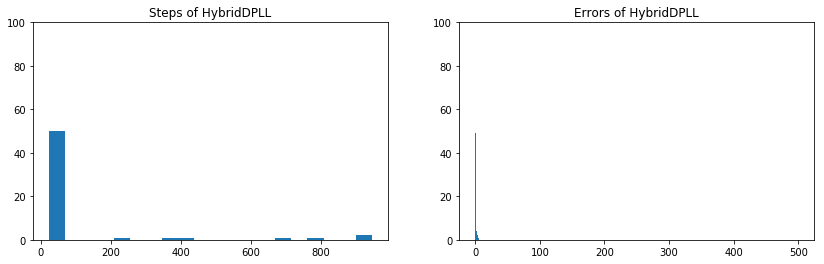

100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


Within 1e6 steps solved 26 problems out of 100
#Sats: 26; avg step: 339.50; stdev step: 292.57; avg error: 3.27; stdev error: 1.35


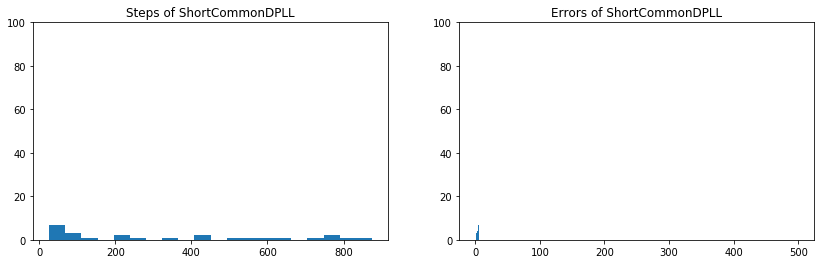

In [26]:
print_all(100, 500, 25)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [04:36<00:00,  2.03s/it]


Within 1e6 steps solved 49 problems out of 100
#Sats: 49; avg step: 48.65; stdev step: 101.11; avg error: 0.14; stdev error: 0.73


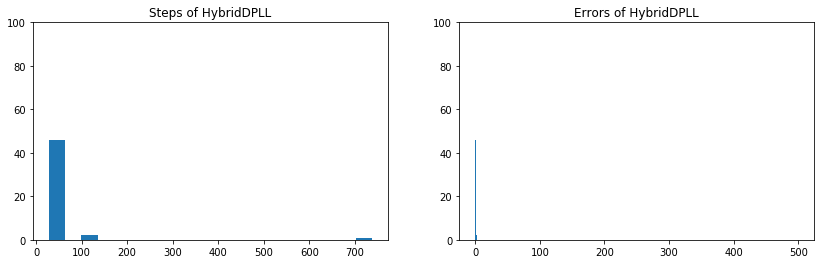

100%|██████████| 100/100 [00:11<00:00,  6.71it/s]


Within 1e6 steps solved 10 problems out of 100
#Sats: 10; avg step: 357.70; stdev step: 321.54; avg error: 2.90; stdev error: 2.07


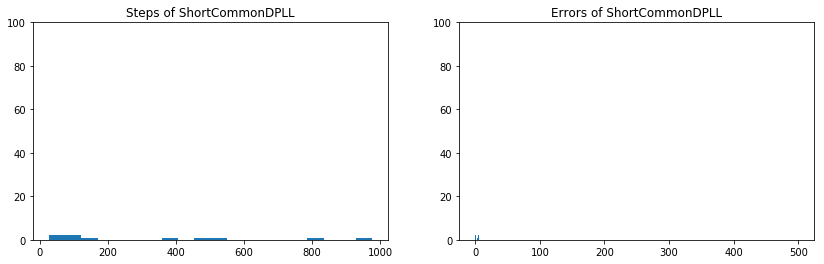

In [27]:
print_all(100, 500, 30, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:46<00:00,  4.54s/it]


Within 1e6 steps solved 1 problems out of 10
#Sats: 1; avg step: 41.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


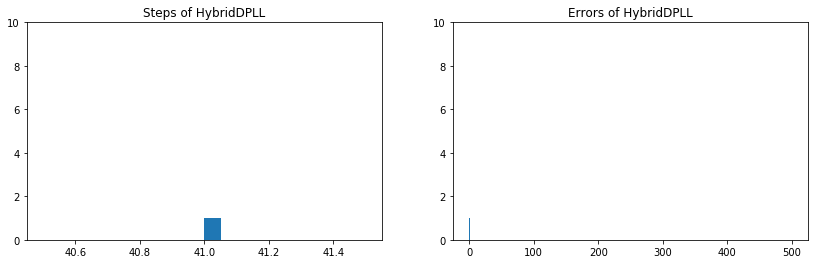

100%|██████████| 10/10 [00:01<00:00,  6.44it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

Within 1e6 steps solved 0 problems out of 10
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


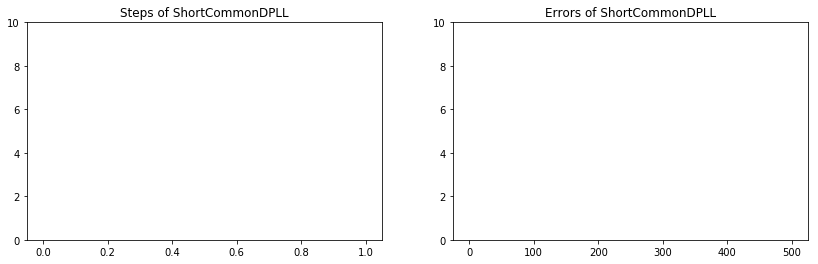

In [28]:
print_all(10, 500, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:54<00:00,  5.60s/it]


Within 1e6 steps solved 4 problems out of 10
#Sats: 4; avg step: 147.00; stdev step: 166.85; avg error: 0.75; stdev error: 1.30


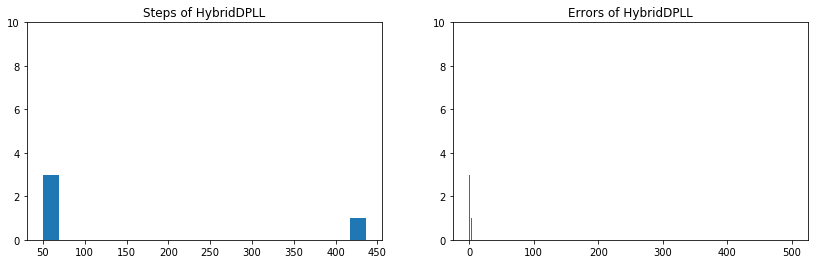

100%|██████████| 10/10 [00:01<00:00,  5.43it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

Within 1e6 steps solved 0 problems out of 10
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


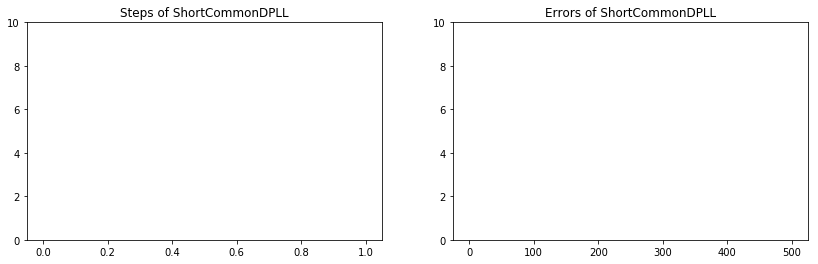

In [29]:
print_all(10, 500, 50, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [04:34<00:00,  2.59s/it]


Within 1e6 steps solved 54 problems out of 100
#Sats: 54; avg step: 117.94; stdev step: 236.56; avg error: 0.50; stdev error: 1.29


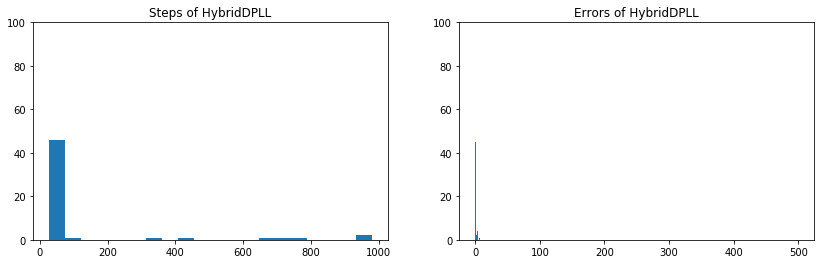

100%|██████████| 100/100 [00:11<00:00,  7.93it/s]


Within 1e6 steps solved 9 problems out of 100
#Sats: 9; avg step: 411.33; stdev step: 288.49; avg error: 3.44; stdev error: 1.17


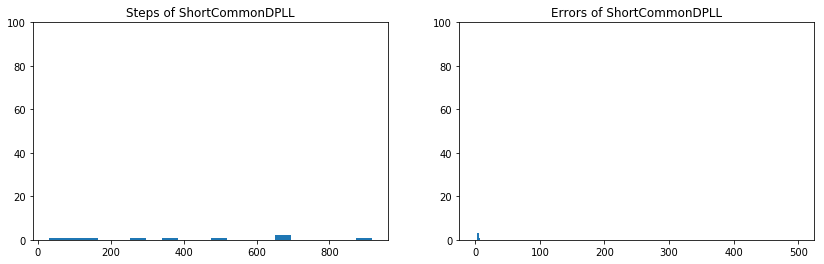

In [30]:
print_all(100, 500, 30, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [07:31<00:00,  3.92s/it]


Within 1e6 steps solved 22 problems out of 100
#Sats: 22; avg step: 74.09; stdev step: 119.61; avg error: 0.41; stdev error: 1.50


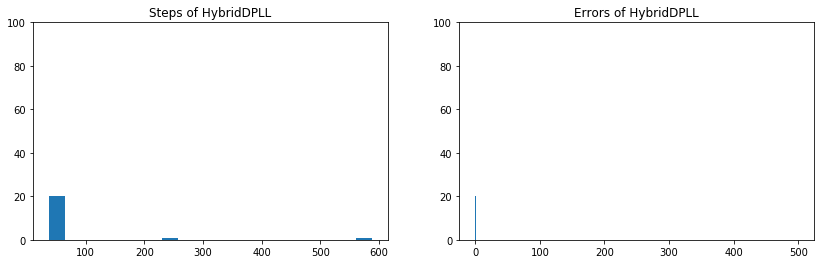

100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Within 1e6 steps solved 5 problems out of 100
#Sats: 5; avg step: 279.00; stdev step: 132.65; avg error: 3.60; stdev error: 1.36


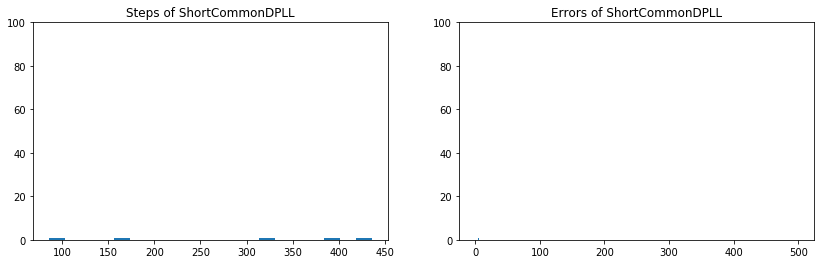

In [31]:
print_all(100, 500, 40, light=True)

100%|██████████| 100/100 [00:00<00:00, 190650.18it/s]

We have generated 100 formulas
Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


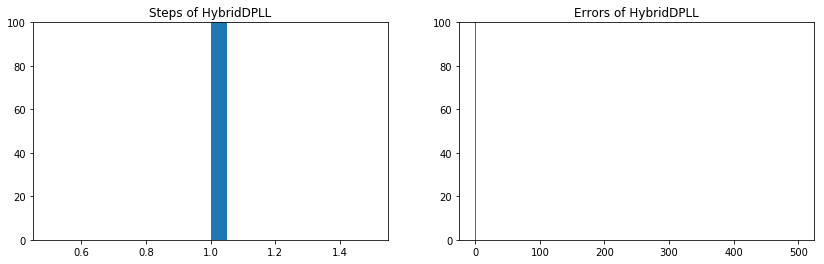

100%|██████████| 100/100 [00:00<00:00, 168513.62it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


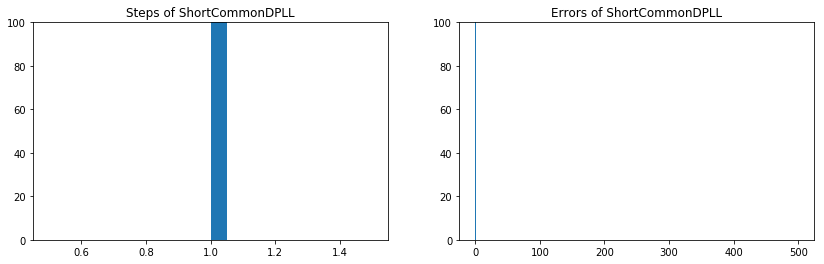

In [32]:
print_all(100, 500, 0, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [09:07<00:00,  4.43s/it]


Within 1e6 steps solved 23 problems out of 100
#Sats: 23; avg step: 50.13; stdev step: 0.90; avg error: 0.00; stdev error: 0.00


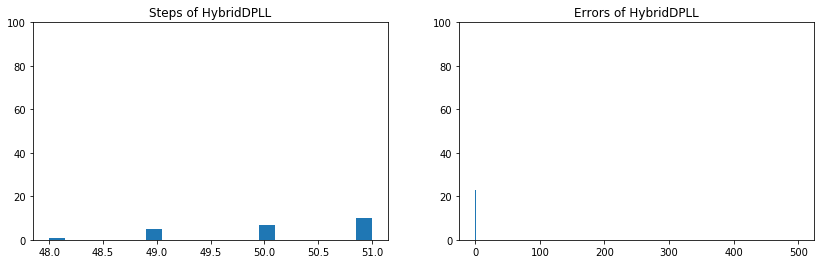

100%|██████████| 100/100 [00:18<00:00,  4.93it/s]


Within 1e6 steps solved 3 problems out of 100
#Sats: 3; avg step: 350.00; stdev step: 253.68; avg error: 3.67; stdev error: 1.25


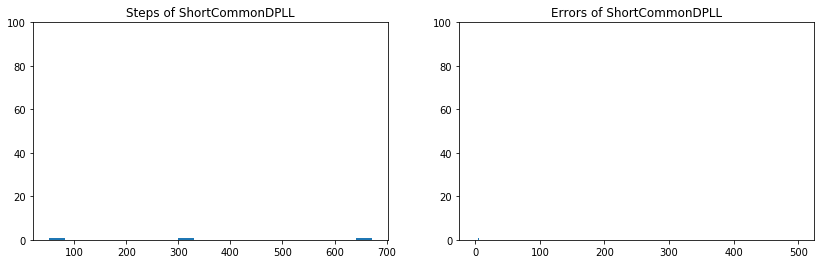

In [33]:
print_all(100, 500, 50, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [14:27<00:00,  8.45s/it]


Within 1e6 steps solved 11 problems out of 100
#Sats: 11; avg step: 88.36; stdev step: 58.71; avg error: 0.36; stdev error: 0.88


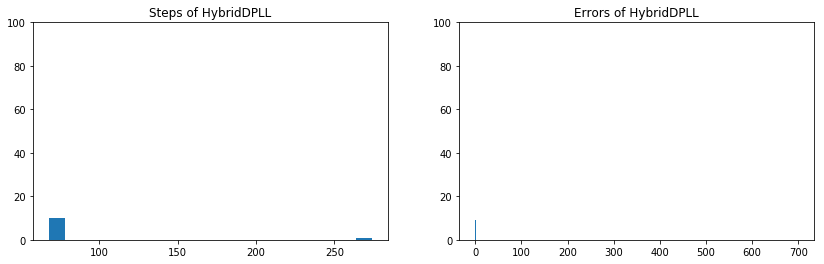

100%|██████████| 100/100 [00:25<00:00,  3.63it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


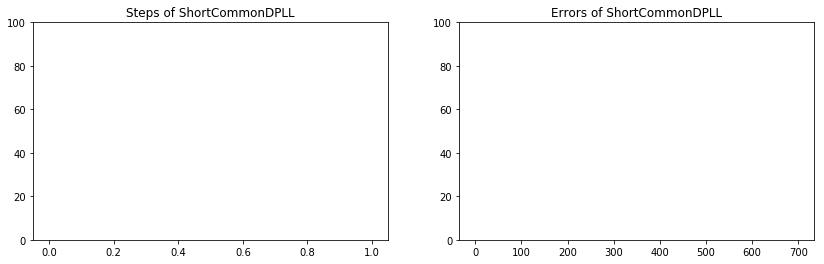

In [34]:
print_all(100, 700, 70, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [21:43<00:00, 12.86s/it]


Within 1e6 steps solved 2 problems out of 100
#Sats: 2; avg step: 130.00; stdev step: 40.00; avg error: 0.50; stdev error: 0.50


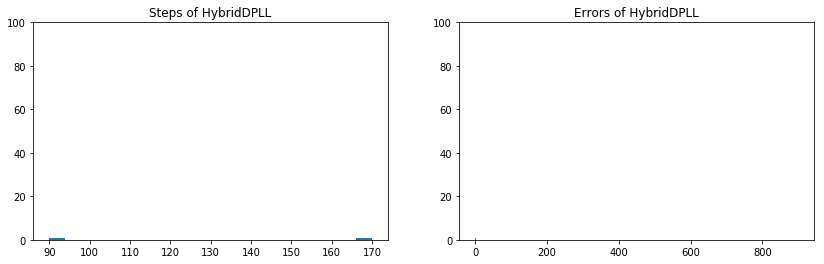

100%|██████████| 100/100 [00:38<00:00,  2.42it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


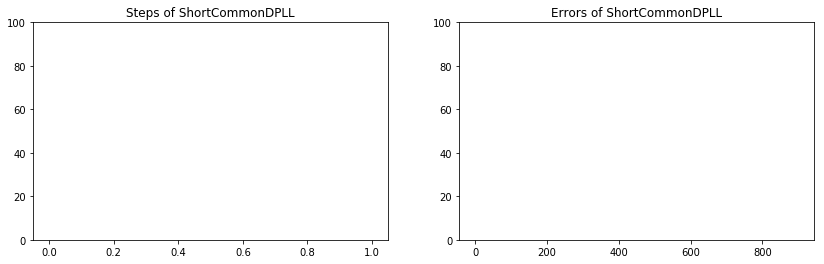

In [35]:
print_all(100, 900, 90, light=True)